# Convolutional Neural Networks from Scratch

[CE477: Machine Learning](https://www.sharifml.ir/)

__Course Instructor__: Dr. Sharifi-Zarchi

__Notebook Author__: Ramtin Moslemi

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SharifiZarchi/Introduction_to_Machine_Learning/blob/main/Jupyter_Notebooks/Chapter_04_Computer_Vision/CNNs_from_scratch.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/SharifiZarchi/Introduction_to_Machine_Learning/main/Jupyter_Notebooks/Chapter_04_Computer_Vision/CNNs_from_scratch.ipynb)

---

## Notebook Objectives

In this notebook we are going to implement and train a convolutional neural network from scratch using only numpy!




In [1]:
# @title imports

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import trange

In [2]:
# @title get sample image
! gdown https://avatars.githubusercontent.com/u/6183533?v=4 -O asharifiz.png

Downloading...
From: https://avatars.githubusercontent.com/u/6183533?v=4
To: /content/asharifiz.png
100% 218k/218k [00:00<00:00, 1.40MB/s]


In [3]:
# @title NNs from scratch

class Layer:
    def __init__(self):
        self.inp = None
        self.out = None

    def __call__(self, inp: np.ndarray) -> np.ndarray:
        return self.forward(inp)

    def forward(self, inp: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def step(self, lr: float) -> None:
        pass


class Linear(Layer):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        # He initialization: better scaling for deep networks
        self.w = 0.1 * np.random.randn(in_dim, out_dim)
        self.b = np.zeros((1, out_dim))
        self.dw = np.zeros_like(self.w)
        self.db = np.zeros_like(self.b)

    def forward(self, inp: np.ndarray) -> np.ndarray:
        """Perform the linear transformation: output = inp * W + b"""
        self.inp = inp
        self.out = np.dot(inp, self.w) + self.b
        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        """Backpropagate the gradients through this layer."""
        # Compute gradients for weights and biases
        self.dw = np.dot(self.inp.T, up_grad)  # Gradient wrt weights
        self.db = np.sum(up_grad, axis=0, keepdims=True)  # Gradient wrt biases
        # Compute gradient to propagate back (downstream)
        down_grad = np.dot(up_grad, self.w.T)
        return down_grad

    def step(self, lr: float) -> None:
        """Update the weights and biases using the gradients."""
        self.w -= lr * self.dw
        self.b -= lr * self.db


class ReLU(Layer):
    def forward(self, inp: np.ndarray) -> np.ndarray:
        """ReLU Activation: f(x) = max(0, x)"""
        self.inp = inp
        self.out = np.maximum(0, inp)
        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        """Backward pass for ReLU: derivative is 1 where input > 0, else 0."""
        down_grad = up_grad * (self.inp > 0)  # Efficient boolean indexing
        return down_grad


class Softmax(Layer):
    def forward(self, inp: np.ndarray) -> np.ndarray:
        """Softmax Activation: f(x) = exp(x) / sum(exp(x))"""
        # Subtract max for numerical stability
        exp_values = np.exp(inp - np.max(inp, axis=1, keepdims=True))
        self.out = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        """Backward pass for Softmax using the Jacobian matrix."""
        down_grad = np.empty_like(up_grad)
        for i in range(up_grad.shape[0]):
            single_output = self.out[i].reshape(-1, 1)
            jacobian = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            down_grad[i] = np.dot(jacobian, up_grad[i])
        return down_grad


class Loss:
    def __init__(self):
        self.prediction = None
        self.target = None
        self.loss = None

    def __call__(self, prediction: np.ndarray, target: np.ndarray) -> float:
        return self.forward(prediction, target)

    def forward(self, prediction: np.ndarray, target: np.ndarray) -> float:
        raise NotImplementedError

    def backward(self) -> np.ndarray:
        raise NotImplementedError


class CrossEntropy(Loss):
    def forward(self, prediction: np.ndarray, target: np.ndarray) -> float:
        """Cross-Entropy Loss for classification."""
        self.prediction = prediction
        self.target = target
        # Clip predictions to avoid log(0)
        clipped_pred = np.clip(prediction, 1e-12, 1.0)
        # Compute and return the loss
        self.loss = -np.mean(np.sum(target * np.log(clipped_pred), axis=1))
        return self.loss

    def backward(self) -> np.ndarray:
        """Gradient of Cross-Entropy Loss."""
        # Gradient wrt prediction (assuming softmax and one-hot targets)
        grad = -self.target / self.prediction / self.target.shape[0]
        return grad


class CNN:
    def __init__(self, layers: list[Layer], loss_fn: Loss, lr: float) -> None:
        """
        Convolutional Neural Network (CNN) class.
        Arguments:
        - layers: List of layers (e.g., Linear, ReLU, etc.).
        - loss_fn: Loss function object (e.g., CrossEntropy, MSE).
        - lr: Learning rate.
        """
        self.layers = layers
        self.loss_fn = loss_fn
        self.lr = lr

    def __call__(self, inp: np.ndarray) -> np.ndarray:
        """Makes the model callable, equivalent to forward pass."""
        return self.forward(inp)

    def forward(self, inp: np.ndarray) -> np.ndarray:
        """Pass input through each layer sequentially."""
        for layer in self.layers:
            inp = layer.forward(inp)
        return inp

    def loss(self, prediction: np.ndarray, target: np.ndarray) -> float:
        """Calculate the loss."""
        return self.loss_fn(prediction, target)

    def backward(self) -> None:
        """Perform backpropagation by propagating the gradient backwards through the layers."""
        up_grad = self.loss_fn.backward()
        for layer in reversed(self.layers):
            up_grad = layer.backward(up_grad)

    def update(self) -> None:
        """Update the parameters of each layer using the gradients and the learning rate."""
        for layer in self.layers:
            layer.step(self.lr)

    def train(self, x_train: np.ndarray, y_train: np.ndarray, epochs: int, batch_size: int) -> np.ndarray:
        """Train the MLP over the given dataset for a number of epochs."""
        losses, accuracies = np.empty(epochs), np.empty(epochs)
        for epoch in (pbar := trange(epochs)):
            running_loss = 0.0
            correct = 0
            for i in range(0, len(x_train), batch_size):
                x_batch = x_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]

                # Forward pass
                prediction = self.forward(x_batch)

                # Compute loss
                running_loss += self.loss(prediction, y_batch) * batch_size

                # Update correct
                correct += np.sum(np.argmax(prediction, axis=1) == np.argmax(y_batch, axis=1))

                # Backward pass
                self.backward()

                # Update parameters
                self.update()

            # Normalize running loss by total number of samples
            running_loss /= len(x_train)
            accuracy = 100 * correct / len(x_train)
            pbar.set_description(f"Loss: {running_loss:.3f} | Accuracy: {accuracy:.2f}% ")
            losses[epoch] = running_loss
            accuracies[epoch] = accuracy
        return losses, accuracies

In [4]:
# @title helper functions

def plot_conv(convolutions=None, img_src='asharifiz.png', sequential=False):
    # Load the image
    img = mpimg.imread(img_src)
    cols = len(convolutions) + 1 if convolutions is not None else 1
    fig, axes = plt.subplots(1, cols, figsize=(15, 15 * cols))

    # Display the image
    axes[0].imshow(img)
    axes[0].axis('off')  # Hide the axis
    axes[0].set_title('Original')

    for i, conv in enumerate(convolutions):
        x = np.transpose(img, (2, 0, 1))
        x = np.expand_dims(x, axis=(0))
        out = conv(x).squeeze()
        out = np.transpose(out, (1, 2, 0))
        axes[i + 1].imshow(out)
        axes[i + 1].axis('off')  # Hide the axis
        axes[i + 1].set_title(f'Filter {i + 1}')
        if sequential:
            img = out

    plt.show()

def plot_results(losses, accuracies):
    # Plot the loss
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(losses) + 1), losses)
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(accuracies) + 1), accuracies)
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_names, kept_classes):
    dim = len(kept_classes)
    labels = [class_names[i] for i in kept_classes]
    # Plot the confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    norm_conf_mat = conf_mat / np.sum(conf_mat, axis=1)
    # plot the matrix
    fig, ax = plt.subplots()
    plt.imshow(norm_conf_mat)
    plt.title('Confusion Matrix')
    plt.xlabel('Predictions')
    plt.ylabel('Labels')
    plt.xticks(range(dim), labels, rotation=45)
    plt.yticks(range(dim), labels)
    plt.colorbar()
    # Put number of each cell in plot
    for i in range(dim):
        for j in range(dim):
            c = conf_mat[j, i]
            color = 'black' if c > 500 else 'white'
            ax.text(i, j, str(int(c)), va='center', ha='center', color=color)
    plt.show()


def get_data(filter_classes):
    fashion_mnist = fetch_openml("Fashion-MNIST", parser='auto')
    x, y = fashion_mnist['data'], fashion_mnist['target'].astype(int)
    # Remove classes
    filtered_indices = np.isin(y, filter_classes)
    x, y = x[filtered_indices].to_numpy(), y[filtered_indices]
    # Normalize the pixels to be in [-1, +1] range
    x = ((x / 255.) - .5) * 2
    removed_class_count = 0
    for i in range(10):  # Fix the labels
        if i in filter_classes and removed_class_count != 0:
            y[y == i] = i - removed_class_count
        elif i not in filter_classes:
            removed_class_count += 1
    # Do the train-test split
    return train_test_split(x, y, test_size=10_000)


def onehot_encoder(y, num_labels):
    one_hot = np.zeros(shape=(y.size, num_labels), dtype=int)
    one_hot[np.arange(y.size), y] = 1
    return one_hot

# Layers

In this notebook we want to implement `Conv2D`, `MaxPool2D`, `AvgPool2D` and `Flatten` layers and train a CNN.




Recall from our notebook [Neural Networks from Scratch](https://colab.research.google.com/github/SharifiZarchi/Introduction_to_Machine_Learning/blob/main/Jupyter_Notebooks/Chapter_03_Neural_Networks/NNs_from_scratch.ipynb) that the abstract `Layer` class is defined as follows:
```
class Layer:
    def __init__(self):
        self.inp = None
        self.out = None

    def __call__(self, inp: np.ndarray) -> np.ndarray:
        return self.forward(inp)

    def forward(self, inp: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def step(self, lr: float) -> None:
        pass

```


## Convolutional Layer
Applies convolution operations to input images by sliding a learnable kernel over them, computing dot products with patches of the input. This helps detect spatial features like edges and textures.


At first, we will build a simple convolutional layer without strides or padding for simplicity.

In [5]:
class SimpleConv2D(Layer):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        # Initialize weights and biases
        self.w = 0.1 * np.random.randn(out_channels, in_channels, kernel_size, kernel_size)
        self.b = np.zeros((out_channels, 1))

    def forward(self, inp: np.ndarray) -> np.ndarray:
        self.inp = inp
        batch_size, in_channels, height, width = inp.shape
        assert in_channels == self.in_channels, "Input channels must match."

        # Output dimensions
        out_height = height - self.kernel_size + 1
        out_width = width - self.kernel_size + 1
        self.out = np.zeros((batch_size, self.out_channels, out_height, out_width))

        # Convolution operation
        for i in range(out_height):
            for j in range(out_width):
                region = inp[:, :, i:i+self.kernel_size, j:j+self.kernel_size]
                self.out[:, :, i, j] = np.tensordot(region, self.w, axes=([1, 2, 3], [1, 2, 3])) + self.b.T

        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        """Backward pass for Conv2D layer."""
        batch_size, in_channels, height, width = self.inp.shape
        _, _, out_height, out_width = up_grad.shape

        # Initialize gradients
        self.dw = np.zeros_like(self.w)
        self.db = np.sum(up_grad, axis=(0, 2, 3), keepdims=True).reshape(self.out_channels, 1)
        down_grad = np.zeros_like(self.inp)

        # Gradient computation for weights and input
        for i in range(out_height):
            for j in range(out_width):
                region = self.inp[:, :, i:i+self.kernel_size, j:j+self.kernel_size]
                self.dw += np.tensordot(up_grad[:, :, i, j], region, axes=([0], [0]))  # Compute weight gradient
                for n in range(batch_size):
                    down_grad[n, :, i:i+self.kernel_size, j:j+self.kernel_size] += np.tensordot(self.w, up_grad[n, :, i, j], axes=(0, 0))

        return down_grad

    def step(self, lr: float) -> None:
        """Update weights and biases."""
        self.w -= lr * self.dw
        self.b -= lr * self.db


Now that you've seen how we can build a simple convolutional layer, let's incorporate stride and padding into our design.

In [6]:
class Conv2D(Layer):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, padding: int = 0):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Initialize weights and biases
        self.w = 0.1 * np.random.randn(out_channels, in_channels, kernel_size, kernel_size)
        self.b = np.zeros((out_channels, 1))

    def forward(self, inp: np.ndarray) -> np.ndarray:
        self.inp = inp
        batch_size, in_channels, height, width = inp.shape

        # Padding the input
        self.padded_inp = np.pad(inp, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant')

        # Output dimensions
        out_height = (height + 2 * self.padding - self.kernel_size) // self.stride + 1
        out_width = (width + 2 * self.padding - self.kernel_size) // self.stride + 1
        self.out = np.zeros((batch_size, self.out_channels, out_height, out_width))

        # Convolution operation
        for i in range(out_height):
            for j in range(out_width):
                region = self.padded_inp[:, :, i*self.stride:i*self.stride+self.kernel_size, j*self.stride:j*self.stride+self.kernel_size]
                self.out[:, :, i, j] = np.tensordot(region, self.w, axes=([1, 2, 3], [1, 2, 3])) + self.b.T

        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        """Backward pass for Conv2D layer."""
        batch_size, in_channels, height, width = self.inp.shape
        _, _, out_height, out_width = up_grad.shape

        # Initialize gradients
        self.dw = np.zeros_like(self.w)
        self.db = np.sum(up_grad, axis=(0, 2, 3), keepdims=True).reshape(self.out_channels, 1)
        down_grad = np.zeros_like(self.padded_inp)

        # Gradient computation for weights and input
        for i in range(out_height):
            for j in range(out_width):
                region = self.padded_inp[:, :, i*self.stride:i*self.stride+self.kernel_size, j*self.stride:j*self.stride+self.kernel_size]
                self.dw += np.tensordot(up_grad[:, :, i, j], region, axes=([0], [0]))  # Compute weight gradient
                for n in range(batch_size):
                    down_grad[n, :, i*self.stride:i*self.stride+self.kernel_size, j*self.stride:j*self.stride+self.kernel_size] += np.tensordot(self.w, up_grad[n, :, i, j], axes=(0, 0))

        # Remove padding if applied
        if self.padding > 0:
            down_grad = down_grad[:, :, self.padding:-self.padding, self.padding:-self.padding]

        return down_grad

    def step(self, lr: float) -> None:
        """Update weights and biases."""
        self.w -= lr * self.dw
        self.b -= lr * self.db

Now lets test our `Conv2D` layer!

In [7]:
x = np.arange(9).reshape(1, 1, 3, 3)
print(x)

convolution = Conv2D(in_channels=1 , out_channels=1, kernel_size=2)
kernel = np.ones(shape=(1, 1, 2, 2))
convolution.w = kernel

print(convolution(x))

[[[[0 1 2]
   [3 4 5]
   [6 7 8]]]]
[[[[ 8. 12.]
   [20. 24.]]]]


## Max Pooling Layer
Reduces the spatial dimensions of the input by selecting the maximum value from non-overlapping regions (windows) of the input. This helps in downsampling and capturing important features.

In [8]:
class MaxPool2D(Layer):
    def __init__(self, pool_size: int = 2, stride: int = 2):
        """Max Pooling Layer."""
        super().__init__()
        self.pool_size = pool_size
        self.stride = stride

    def forward(self, inp: np.ndarray) -> np.ndarray:
        """Forward pass of max pooling."""
        self.inp = inp
        batch_size, channels, height, width = inp.shape

        out_height = (height - self.pool_size) // self.stride + 1
        out_width = (width - self.pool_size) // self.stride + 1

        out = np.zeros((batch_size, channels, out_height, out_width))

        for i in range(out_height):
            for j in range(out_width):
                region = inp[:, :, i*self.stride:i*self.stride+self.pool_size, j*self.stride:j*self.stride+self.pool_size]
                out[:, :, i, j] = np.max(region, axis=(2, 3))

        self.out = out
        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        """Backward pass for max pooling."""
        batch_size, channels, height, width = self.inp.shape
        down_grad = np.zeros_like(self.inp)

        out_height, out_width = up_grad.shape[2], up_grad.shape[3]

        for i in range(out_height):
            for j in range(out_width):
                region = self.inp[:, :, i*self.stride:i*self.stride+self.pool_size, j*self.stride:j*self.stride+self.pool_size]
                max_mask = (region == np.max(region, axis=(2, 3), keepdims=True))
                down_grad[:, :, i*self.stride:i*self.stride+self.pool_size, j*self.stride:j*self.stride+self.pool_size] += max_mask * up_grad[:, :, i, j][:, :, None, None]

        return down_grad

Now lets test our `MaxPool2D` layer!

In [9]:
x = np.arange(16).reshape(1, 1, 4, 4)
print(x)

maxpool = MaxPool2D()
print(maxpool(x))

[[[[ 0  1  2  3]
   [ 4  5  6  7]
   [ 8  9 10 11]
   [12 13 14 15]]]]
[[[[ 5.  7.]
   [13. 15.]]]]


## Average Pooling Layer
Similar to MaxPooling, but instead of taking the maximum value, it averages the values in each window. This smoothens the features while reducing spatial dimensions.

In [10]:
class AvgPool2D(Layer):
    def __init__(self, pool_size: int = 2, stride: int = 2):
        """Average Pooling Layer."""
        super().__init__()
        self.pool_size = pool_size
        self.stride = stride

    def forward(self, inp: np.ndarray) -> np.ndarray:
        """Forward pass of average pooling."""
        self.inp = inp
        batch_size, channels, height, width = inp.shape

        out_height = (height - self.pool_size) // self.stride + 1
        out_width = (width - self.pool_size) // self.stride + 1

        out = np.zeros((batch_size, channels, out_height, out_width))

        for i in range(out_height):
            for j in range(out_width):
                region = inp[:, :, i*self.stride:i*self.stride+self.pool_size, j*self.stride:j*self.stride+self.pool_size]
                out[:, :, i, j] = np.mean(region, axis=(2, 3))

        self.out = out
        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        """Backward pass for average pooling."""
        batch_size, channels, height, width = self.inp.shape
        down_grad = np.zeros_like(self.inp)

        out_height, out_width = up_grad.shape[2], up_grad.shape[3]

        for i in range(out_height):
            for j in range(out_width):
                region_grad = up_grad[:, :, i, j][:, :, None, None] / (self.pool_size * self.pool_size)
                down_grad[:, :, i*self.stride:i*self.stride+self.pool_size, j*self.stride:j*self.stride+self.pool_size] += region_grad

        return down_grad

Now lets test our `AvgPool2D` layer!

In [11]:
x = np.arange(16).reshape(1, 1, 4, 4)
print(x)

avgpool = AvgPool2D()
print(avgpool(x))

[[[[ 0  1  2  3]
   [ 4  5  6  7]
   [ 8  9 10 11]
   [12 13 14 15]]]]
[[[[ 2.5  4.5]
   [10.5 12.5]]]]


## Flatten
Reshapes a multi-dimensional input (like an image) into a single vector. This is typically used to transition from convolutional layers to fully connected layers in a neural network.

In [12]:
class Flatten(Layer):
    def forward(self, inp: np.ndarray) -> np.ndarray:
        """Flatten the input into a 2D array."""
        self.inp_shape = inp.shape
        return inp.reshape(self.inp_shape[0], -1)

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        """Reshape the gradient back to the original input shape."""
        return up_grad.reshape(self.inp_shape)

Now lets test our `Flatten` layer!

In [13]:
x = np.arange(9).reshape(1, 1, 3, 3)
print(x)

flatten = Flatten()
print(flatten(x))

[[[[0 1 2]
   [3 4 5]
   [6 7 8]]]]
[[0 1 2 3 4 5 6 7 8]]


# Visualizations

In [14]:
# @title Custome Kernels

# Black and White Kernel
black_and_white = Conv2D(in_channels=3 , out_channels=3, kernel_size=3)
black_and_white.w = np.ones(shape=(3, 3, 3, 3)) / 27


# Red Channel
red = Conv2D(in_channels=3, out_channels=3, kernel_size=1)
red.w = np.zeros_like(red.w)
red.w[0, 0, :, :] = np.array([1])


# Green Channel
green = Conv2D(in_channels=3, out_channels=3, kernel_size=1)
green.w = np.zeros_like(green.w)
green.w[1, 1, :] = np.array([1])


# Blue Channel
blue = Conv2D(in_channels=3, out_channels=3, kernel_size=1)
blue.w = np.zeros_like(blue.w)
blue.w[2, 2, :] = np.array([1])


# Gaussian Blur Kernel
gaussian3 = Conv2D(in_channels=3, out_channels=3, kernel_size=3)
for i in range(3):
    for j in range(3):
        if i == j:
            gaussian3.w[i, j, :, :] = np.array([[1, 2, 1],
                                                [2, 4, 2],
                                                [1, 2, 1]]) / 16
        else:
            gaussian3.w[i, j, :, :] = 0


# Gaussian Blur Kernel
gaussian5 = Conv2D(in_channels=3, out_channels=3, kernel_size=5)
for i in range(3):
    for j in range(3):
        if i == j:
            gaussian5.w[i, j, :, :] = np.array([[1, 4, 6, 4, 1],
                                                [4, 16, 24, 16, 4],
                                                [6, 24, 36, 24, 6],
                                                [4, 16, 24, 16, 4],
                                                [1, 4, 6, 4, 1]]) / 256
        else:
            gaussian5.w[i, j, :, :] = 0


# Sobel (Vertical)
sobel_v = Conv2D(in_channels=3, out_channels=3, kernel_size=3)
for i in range(3):
    for j in range(3):
        if i == j:
            sobel_v.w[i, j, :, :] = np.array([[1, 0, -1],
                                              [2, 0, -2],
                                              [1, 0, -1]])
        else:
            sobel_v.w[i, j, :, :] = 0

# Sobel (Horizontal)
sobel_h = Conv2D(in_channels=3, out_channels=3, kernel_size=3)
for i in range(3):
    for j in range(3):
        if i == j:
            sobel_h.w[i, j, :, :] = np.array([[1, 2, 1],
                                              [0, 0, 0],
                                              [-1, -2, -1]])
        else:
            sobel_h.w[i, j, :, :] = 0


# Max Pool
max_pool = MaxPool2D()

# Average Pool
avg_pool = AvgPool2D()

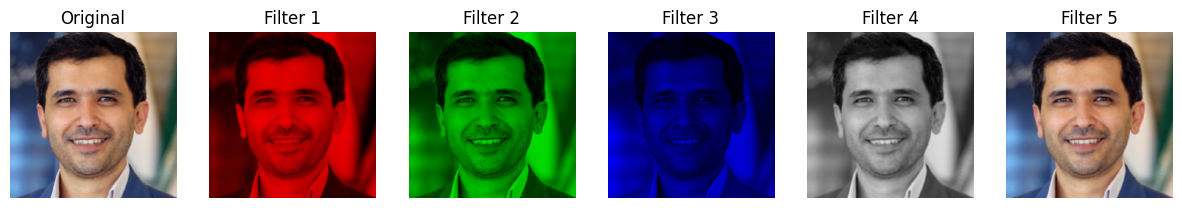

In [15]:
plot_conv(convolutions=[red, green, blue, black_and_white, avg_pool])

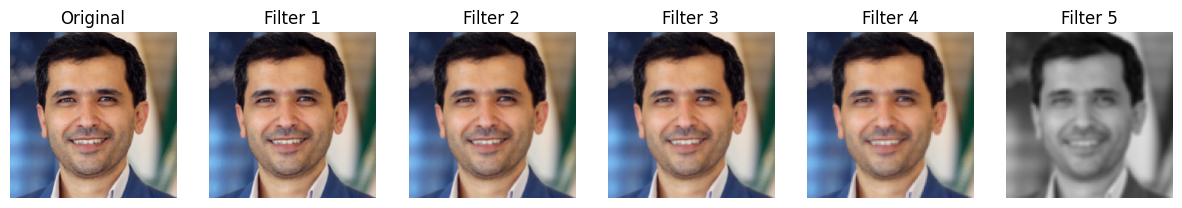

In [16]:
plot_conv(convolutions=[gaussian3, gaussian5, max_pool,
                        avg_pool, black_and_white],
          sequential=True)

# Training

## Loading the Fashion-MNIST Dataset

For simplicity you can use `get_data` to load the Fashion-MNIST dataset. Since we aren't using GPUs, in order to save time and get better results, we are only going to include 3 classes in our training. However you can easily modify this cell to include different classes.

In [17]:
class_names = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover',
               3: 'Dress', 4: 'Coat', 5:  'Sandal', 6: 'Shirt',
               7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

# Include all the classes you want to see in training
kept_classes = [0, 1, 7]  # T-shirt/top, Trouser, Sneaker

# Download the dataset and split it into training and testing sets
x_train, x_test, y_train, y_test = get_data(kept_classes)

# Reshape the images for the convolutional neural network
x_train = x_train.reshape(-1, 1, 28, 28)
x_test = x_test.reshape(-1, 1, 28, 28)

# One-hot encode the target labels of the training set
y_train = onehot_encoder(y_train, num_labels=len(kept_classes))

## Training the Network

Now we can define the network and train it on the dataset.

Loss: 0.044 | Accuracy: 98.74% : 100%|██████████| 30/30 [14:24<00:00, 28.81s/it]


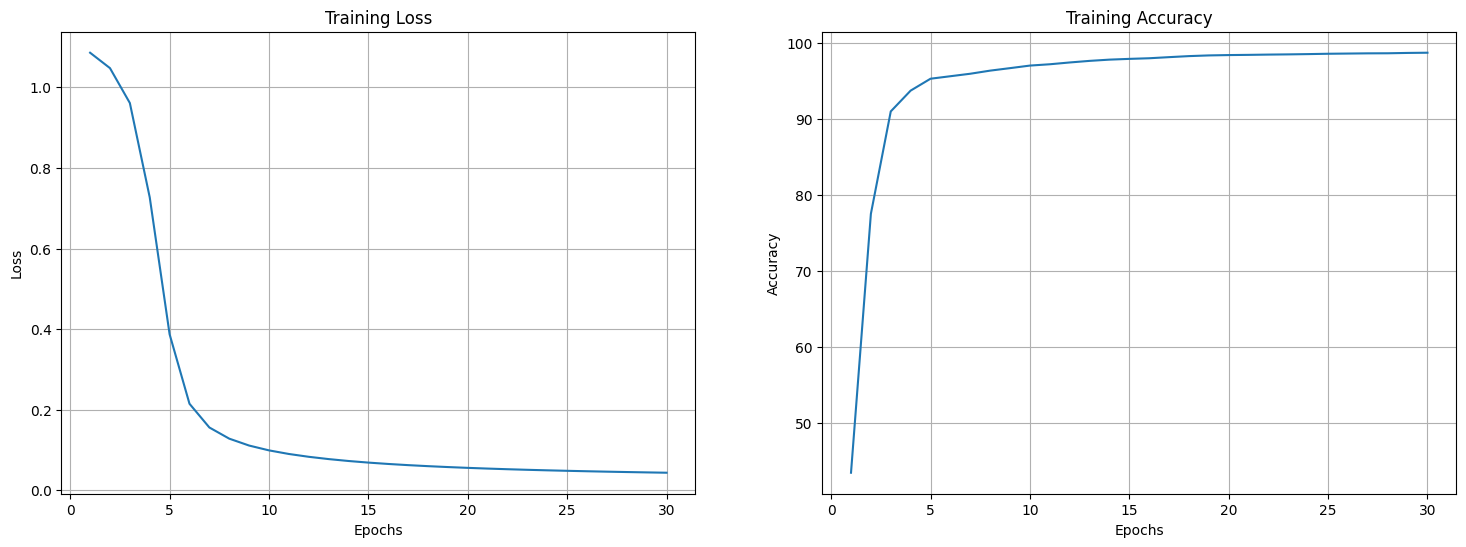

In [18]:
# Define the layers of the neural network
layers = [Conv2D(1, 4, 7, stride=3),
          ReLU(),
          MaxPool2D(),
          Conv2D(4, 4, 3, padding=1),
          ReLU(),
          MaxPool2D(),
          Flatten(),
          ReLU(),
          Linear(16, len(kept_classes)),
          Softmax()]

# Create the model
model = CNN(layers, CrossEntropy(), lr=0.001)

# Train the model
results = model.train(x_train, y_train, epochs=30, batch_size=16)

# Plot the loss curve and accuracies
plot_results(*results)

# Evaluation

We can measure the models accuracy on the test dataset.

In [19]:
# Test the model
y_prediction = np.argmax(model(x_test), axis=1)
acc = 100 * np.mean(y_prediction == y_test)
print(f'Test accuracy with {len(y_train)} training examples on {len(y_test)} test samples is {acc:.2f}%')

Test accuracy with 11000 training examples on 10000 test samples is 98.51%


The confusion matrix can also be observed:

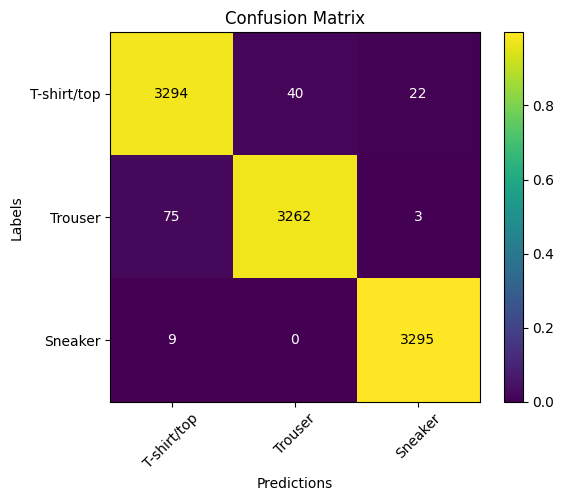

In [20]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_prediction, class_names, kept_classes)

# PyTorch

Here we implement the same CNN but we use PyTorch instead of coding it from scratch.

In [21]:
# @title imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

In [22]:
# @title dataset

def get_data(filter_classes):
    # Download and prepare the dataset
    trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

    # Function to filter dataset and remap labels
    def filter_and_remap(dataset, filter_classes):
        data = dataset.data.numpy()
        targets = dataset.targets.numpy()

        # Remove classes
        filtered_indices = np.isin(targets, filter_classes)
        data, targets = data[filtered_indices], targets[filtered_indices]

        # Normalize the pixels to be in [-1, +1] range
        data = ((data / 255.0) - 0.5) * 2

        # Remap labels
        removed_class_count = 0
        for i in range(10):
            if i in filter_classes and removed_class_count != 0:
                targets[targets == i] = i - removed_class_count
            elif i not in filter_classes:
                removed_class_count += 1

        # Update the dataset
        dataset.data = torch.tensor(data, dtype=torch.float32)
        dataset.targets = torch.tensor(targets, dtype=torch.long)
        return dataset

    # Filter and remap the train and test datasets
    trainset = filter_and_remap(trainset, filter_classes)
    testset = filter_and_remap(testset, filter_classes)

    return trainset, testset


kept_classes = [0, 1, 7]  # T-shirt/top, Trouser, Sneaker
trainset, testset = get_data(kept_classes)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)

In [23]:
# @title helper functions

def train_epoch(model, dataloader, loss_fn, optimizer):
    model.train()
    train_loss = 0.
    train_acc = 0.
    for images, labels in dataloader:
        images, labels = images, labels
        optimizer.zero_grad()
        logits = model(images)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (logits.argmax(dim=1) == labels).sum().item()
    train_loss /= len(dataloader)
    train_acc /= len(dataloader.dataset)
    return train_loss, 100 * train_acc

def train_model(model, loader, optimizer, n_epochs):
    losses, accuracies = np.empty(n_epochs), np.empty(n_epochs)
    loss_fn = nn.CrossEntropyLoss()
    for i in (pbar := trange(n_epochs)):
        loss, acc = train_epoch(model, loader, loss_fn, optimizer)
        losses[i], accuracies[i] = loss, acc
        pbar.set_description(f'Loss: {loss:.3f} | Accuracy: {acc:.2f}% ')
    return losses, accuracies

def test_model(model, loader):
    model.eval()
    acc = 0.
    y_test, y_prediction =[], []
    with torch.no_grad():
        for images, labels in loader:
            logits = model(images)
            pred = logits.argmax(dim=1)
            acc += (pred == labels).sum().item()
            y_test.extend(labels.numpy())
            y_prediction.extend(pred.numpy())
    size = len(loader.dataset)
    acc = 100 * acc / size
    print(f'Test accuracy on {size} test samples is {acc:.2f}%')
    return y_test, y_prediction

Loss: 0.121 | Accuracy: 96.18% : 100%|██████████| 30/30 [04:01<00:00,  8.04s/it]


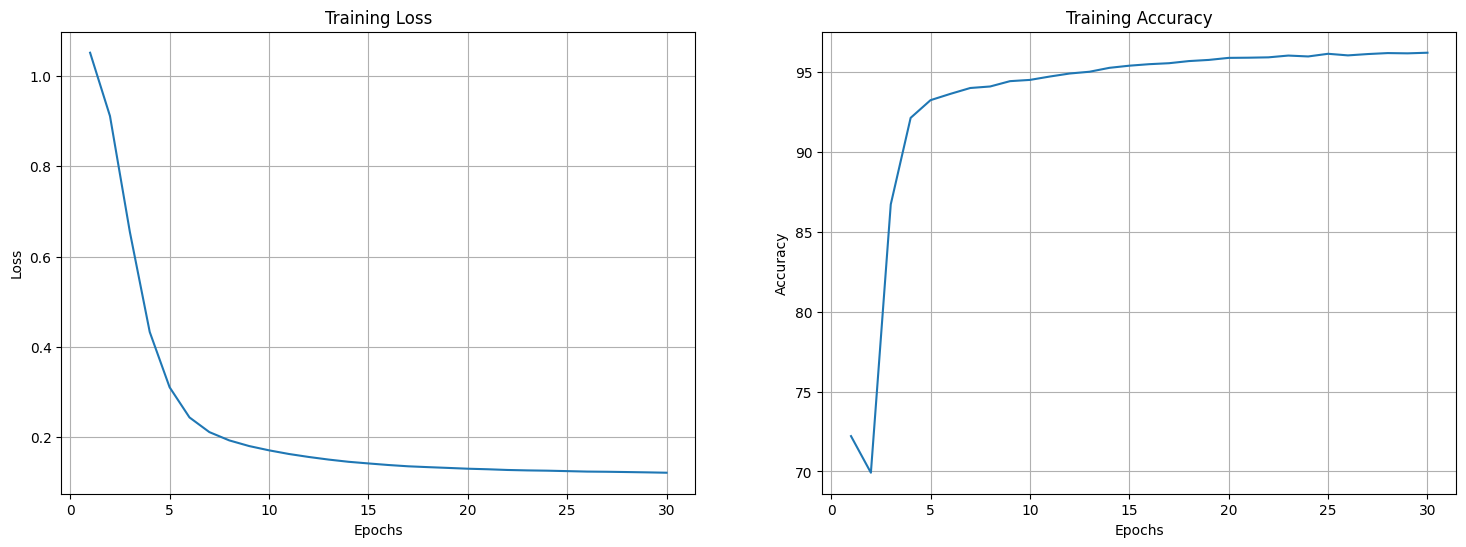

In [24]:
# Create the model
model = nn.Sequential(nn.Conv2d(1, 4, kernel_size=7, stride=3),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Conv2d(4, 4, kernel_size=3, padding=1),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Flatten(),
                      nn.ReLU(),
                      nn.Linear(16, len(kept_classes)))

# Setup the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Train the model
results = train_model(model, trainloader, optimizer, n_epochs=30)

# Plot the loss curve and accuracies
plot_results(*results)

Test accuracy on 3000 test samples is 95.93%


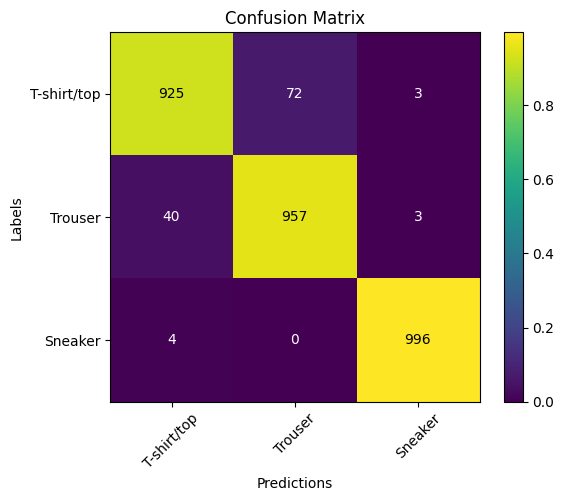

In [25]:
# Test the model
y_test, y_pred = test_model(model, testloader)

# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names, kept_classes)